# Assess the Poisson estimator

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/scmemo')
import estimator, simulate

In [4]:
import sys
sys.path.append('/home/ssm-user/Github/single_cell_eb/')
sys.path.append('/home/ssm-user/Github/single_cell_eb/sceb')
import scdd

### Check 1D estimates of `sceb` with `scmemo`

Using the Poisson model. The outputs should be identical, this is for checking the implementation. 

In [7]:
data = sp.sparse.csr_matrix(simulate.simulate_transcriptomes(100, 20))
adata = sc.AnnData(data)
size_factors = scdd.dd_size_factor(adata)

In [8]:
_, M_dd = scdd.dd_1d_moment(adata, size_factor=size_factors)
var_scdd = scdd.M_to_var(M_dd)
print(var_scdd)

#time start: 0.0s
n_cell=100, n_gene=20
#total: 0.00s
[2.46732679e+00 5.32861629e+00 1.29443925e+00 4.47258165e+01
 1.28390262e+03 2.30193077e+00 2.76952964e+01 1.43530303e+01
 6.56739537e+02 2.50213566e+00 3.09296118e+00 1.30187918e+02
 3.33908553e+02 3.57209764e+01 1.57631203e-01 8.70112402e+00
 2.02505921e-01 6.35272594e+02 1.56207273e+01 1.09610243e+02]


In [9]:
imp.reload(estimator)
mean_scmemo, var_scmemo = estimator._poisson_1d(data, data.shape[0], size_factors)
print(var_scmemo)

[2.46732686e+00 5.32861737e+00 1.29443902e+00 4.47258266e+01
 1.28390533e+03 2.30193159e+00 2.76952837e+01 1.43530281e+01
 6.56752440e+02 2.50213585e+00 3.09296109e+00 1.30187803e+02
 3.33908496e+02 3.57204463e+01 1.57631197e-01 8.70112575e+00
 2.02505913e-01 6.35275520e+02 1.56207403e+01 1.09610173e+02]


In [10]:
df = pd.DataFrame()
df['size_factor'] = size_factors
df['inv_size_factor'] = 1/size_factors
df['inv_size_factor_sq'] = 1/size_factors**2
df['expr'] = data[:, 0].todense().A1
precomputed_size_factors = df.groupby('expr')['inv_size_factor'].mean(), df.groupby('expr')['inv_size_factor_sq'].mean()

In [14]:
imp.reload(estimator)
expr, count = np.unique(data[:, 0].todense().A1, return_counts=True)
print(estimator._poisson_1d((expr, count), data.shape[0], precomputed_size_factors))

[0.21386682510375976, 2.467327020205426]


### Check 2D estimates of `sceb` and `scmemo`

Using the Poisson model. The outputs should be identical, this is for checking the implementation. 

In [696]:
data = sp.sparse.csr_matrix(simulate.simulate_transcriptomes(1000, 4))
adata = sc.AnnData(data)
size_factors = scdd.dd_size_factor(adata)

In [699]:
mean_scdd, cov_scdd, corr_scdd = scdd.dd_covariance(adata, size_factors)
print(cov_scdd)

[[  28.45380815   -0.57224207   -5.18922234  -25.59848495]
 [  -0.57224207   98.7212123   -16.59349467 -111.85287159]
 [  -5.18922234  -16.59349467  184.74122239 -180.3670556 ]
 [ -25.59848495 -111.85287159 -180.3670556   221.84084866]]


In [735]:
imp.reload(estimator)
cov_scmemo = estimator._poisson_cov(data, data.shape[0], size_factors, idx1=[0, 1, 2], idx2=[1, 2, 3])
print(cov_scmemo)

[[  -0.57224207   -5.18922234  -25.59848495]
 [  98.72121234  -16.59349467 -111.85287159]
 [ -16.59349467  184.74122241 -180.3670556 ]]


In [762]:
expr, count = np.unique(data[:, :2].toarray(), return_counts=True, axis=0)

df = pd.DataFrame()
df['size_factor'] = size_factors
df['inv_size_factor'] = 1/size_factors
df['inv_size_factor_sq'] = 1/size_factors**2
df['expr1'] = data[:, 0].todense().A1
df['expr2'] = data[:, 1].todense().A1

precomputed_size_factors = df.groupby(['expr1', 'expr2'])['inv_size_factor'].mean(), df.groupby(['expr1', 'expr2'])['inv_size_factor_sq'].mean()

In [763]:
cov_scmemo = estimator._poisson_cov((expr[:, 0], expr[:, 1], count), data.shape[0], size_factors=precomputed_size_factors)
print(cov_scmemo)

-0.5722419010489546


### Variance/correlation estimation while varying q_sq

In [422]:
q = 0.1
q_sq_list =[0.1**2+1e-6, 0.0102, 0.0106, 0.012]

In [414]:
import warnings
warnings.filterwarnings("ignore")


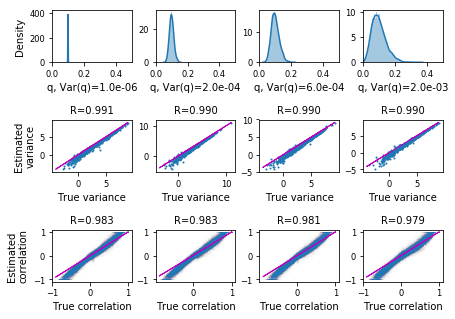

In [449]:
plt.figure(figsize=(7, 5))
plt.subplots_adjust(hspace=1.1, wspace=0.3)
num_subplot_col = len(q_sq_list)
num_subplot_row = 3

for col_num, q_sq in enumerate(q_sq_list):
    
    true_data = simulate.simulate_transcriptomes(5000, 1000, correlated=True)
    qs, captured_data = simulate.capture_sampling(true_data, q, q_sq)
    adata = sc.AnnData(sp.sparse.csr_matrix(captured_data))

    
    x_true, y_true = np.log(true_data.mean(axis=0)), np.log(true_data.var(axis=0))
    x_obs, y_obs = np.log(captured_data.mean(axis=0)), np.log(captured_data.var(axis=0))
    
    _, M_dd = scdd.dd_1d_moment(adata, size_factor=scdd.dd_size_factor(adata), verbose=False)
    var_scdd = scdd.M_to_var(M_dd)/q**2
    
    mean_scdd, _, corr_scdd = scdd.dd_covariance(adata, size_factor=scdd.dd_size_factor(adata))
    corr_scdd[corr_scdd == 0] = np.nan
    
    condition = np.log(var_scdd) > -20
    
    true_corrs = np.corrcoef(true_data, rowvar=False).ravel()
    estimated_corrs = corr_scdd.ravel()
    corr_cond = np.isfinite(estimated_corrs)
    true_corrs = true_corrs[corr_cond]
    estimated_corrs = estimated_corrs[corr_cond]
    
    plt.subplot(num_subplot_row, num_subplot_col, col_num+1)
    sns.distplot(qs)
    plt.xlabel('q, Var(q)={:.1e}'.format(q_sq-q**2))
    plt.xlim(0, 0.5)
    if col_num == 0:
        plt.ylabel('Density')
        
    plt.subplot(num_subplot_row, num_subplot_col, col_num+1+num_subplot_col)
    plt.plot(y_true, y_true, color='m', lw=1)
    plt.scatter(y_true[condition], np.log(var_scdd)[condition], s=1)
    plt.xlabel('True variance');
    if col_num == 0:
        plt.ylabel('Estimated\nvariance')
    plt.title('R={:.3f}'.format(stats.pearsonr(np.log(var_scdd)[condition], y_true[condition])[0]))
    
    sample_idxs = np.random.choice(estimated_corrs.shape[0], 5000, replace=False)
    plt.subplot(num_subplot_row, num_subplot_col, col_num+1+num_subplot_col*2)
    plt.plot(true_corrs, true_corrs, color='m', lw=1)
    plt.scatter(true_corrs, estimated_corrs, s=.01, alpha=0.01)
    plt.xlabel('True correlation');
    if col_num == 0:
        plt.ylabel('Estimated\ncorrelation')
    plt.title('R={:.3f}'.format(stats.pearsonr(true_corrs, estimated_corrs)[0]))
    

In [637]:
plt.figure(figsize=(7, 5))
plt.subplots_adjust(hspace=1.1, wspace=0.3)
num_subplot_col = len(q_sq_list)
num_subplot_row = 3

q_sq = 0.011
true_data = simulate.simulate_transcriptomes(5000, 1000, correlated=False)
qs, captured_data = simulate.capture_sampling(true_data, q, q_sq)
adata = sc.AnnData(sp.sparse.csr_matrix(captured_data))


x_true, y_true = np.log(true_data.mean(axis=0)), np.log(true_data.var(axis=0))
x_obs, y_obs = np.log(captured_data.mean(axis=0)), np.log(captured_data.var(axis=0))

_, M_dd = scdd.dd_1d_moment(adata, size_factor=scdd.dd_size_factor(adata), verbose=False)
var_scdd = scdd.M_to_var(M_dd)/q**2

mean_scdd, _, corr_scdd = scdd.dd_covariance(adata, size_factor=None)
corr_scdd[corr_scdd == 0] = np.nan

condition = np.log(var_scdd) > -20

true_corrs = np.corrcoef(true_data, rowvar=False).ravel()
estimated_corrs = corr_scdd.ravel()
corr_cond = np.isfinite(estimated_corrs)
true_corrs = true_corrs[corr_cond]
estimated_corrs = estimated_corrs[corr_cond]
    
    

<Figure size 504x360 with 0 Axes>

In [565]:
size_factors = scdd.dd_size_factor(adata)
one_gene_data = captured_data[:, 1]

In [566]:
true_data[:, 1].var()

110.39632763999998

In [567]:
var_scdd[1]

98.58771295507152

In [568]:
M_dd[1][1]

2.6418814659118652

In [569]:
((one_gene_data/size_factors)**2).mean()-(one_gene_data/size_factors**2).mean()

2.6418814714856813

In [590]:
((one_gene_data/size_factors)**2).mean()-(one_gene_data/size_factors**2).mean()

array([1.2091846 , 1.1135845 , 1.0489603 , 1.0017892 , 0.9314381 ,
       0.9136544 , 0.8358464 , 0.8363028 , 0.90861374, 0.8686444 ,
       0.8365793 , 0.7526174 , 0.71429   , 0.66574705], dtype=float32)

In [595]:
((one_gene_data/size_factors)**2).mean()

4.0687745719300805

In [608]:
(expr**2*count*df.groupby('expr')['inv_cell_size_sq'].mean()).sum()/count.sum() - (expr*count*df.groupby('expr')['inv_cell_size_sq'].mean()).sum()/count.sum()

2.641881494450569

In [609]:
#Real bootstrap
real_boot_vars = []
for trial in range(5000):
    
    boot_idxs = np.random.choice(one_gene_data.shape[0], one_gene_data.shape[0])
    expr = one_gene_data[boot_idxs]
    second = ((one_gene_data[boot_idxs]/size_factors[boot_idxs])**2).mean()-(one_gene_data[boot_idxs]/size_factors[boot_idxs]**2).mean()
    first = (one_gene_data[boot_idxs]/size_factors[boot_idxs]).mean()
    
    real_boot_vars.append(second)
real_boot_vars = np.array(real_boot_vars)

In [617]:
expr, count = np.unique(one_gene_data, return_counts=True)
freq = count/count.sum()
multi_rvs = stats.multinomial.rvs(one_gene_data.shape[0], freq, size=1000)

In [624]:
approx_boot_vars = (expr**2*multi_rvs*df.groupby('expr')['inv_cell_size_sq'].mean().values).sum(axis=1)/count.sum() - \
    (expr*multi_rvs*df.groupby('expr')['inv_cell_size_sq'].mean().values).sum(axis=1)/count.sum()

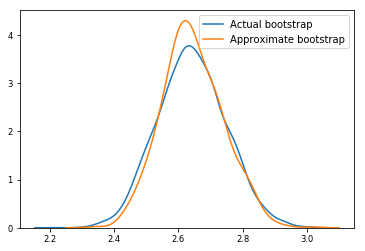

In [629]:
sns.distplot(real_boot_vars, label='Actual bootstrap', hist=False)
sns.distplot(approx_boot_vars, label='Approximate bootstrap', hist=False)
plt.legend()

In [600]:
df = pd.DataFrame()
df['cell_size'] = size_factors
df['cell_size_sq'] = size_factors**2
df['inv_cell_size'] = 1/size_factors
df['inv_cell_size_sq'] = 1/(size_factors**2)
df['expr'] = one_gene_data

In [601]:
inv_cell_sizes = df.groupby('expr')['inv_cell_size'].mean().values
cell_sizes = df.groupby('expr')['cell_size'].mean().values

In [602]:
expr, count = np.unique(one_gene_data, return_counts=True)
freq = count/count.sum()
multi_rvs = stats.multinomial.rvs(one_gene_data.shape[0], freq, size=1000)

In [578]:
(expr**2*count).sum()/count.sum()

4.1872

In [554]:
multi_rvs.shape

(1000, 14)

In [539]:
#approx bootstrap
approx_boot_vars = []
expr, count = np.unique(one_gene_data, return_counts=True)


for trial in range(1):
    
    boot_idxs = np.random.choice(one_gene_data.shape[0], one_gene_data.shape[0])
    expr = one_gene_data[boot_idxs]
    second = ((one_gene_data[boot_idxs]/size_factors[boot_idxs])**2).mean()-(one_gene_data[boot_idxs]/size_factors[boot_idxs]**2).mean()
    first = (one_gene_data[boot_idxs]/size_factors[boot_idxs]).mean()
    
    approx_boot_vars.append( (second-first**2)/q**2 )
approx_boot_vars = np.array(real_boot_vars)

# HAHHAHAHA

In [ ]:
plt.figure(figsize=(7, 5))
plt.subplots_adjust(hspace=1.1, wspace=0.3)
num_subplot_col = len(q_sq_list)
num_subplot_row = 3

q_sq = 0.011
true_data = simulate.simulate_transcriptomes(5000, 1000, correlated=False)
qs, captured_data = simulate.capture_sampling(true_data, q, q_sq)
adata = sc.AnnData(sp.sparse.csr_matrix(captured_data))


x_true, y_true = np.log(true_data.mean(axis=0)), np.log(true_data.var(axis=0))
x_obs, y_obs = np.log(captured_data.mean(axis=0)), np.log(captured_data.var(axis=0))

_, M_dd = scdd.dd_1d_moment(adata, size_factor=scdd.dd_size_factor(adata), verbose=False)
var_scdd = scdd.M_to_var(M_dd)/q**2

mean_scdd, _, corr_scdd = scdd.dd_covariance(adata, size_factor=None)
corr_scdd[corr_scdd == 0] = np.nan

true_corrs = np.corrcoef(true_data, rowvar=False).ravel()
estimated_corrs = corr_scdd.ravel()
corr_cond = np.isfinite(estimated_corrs)
true_corrs = true_corrs[corr_cond]
estimated_corrs = estimated_corrs[corr_cond]
    
condition = np.log(var_scdd) > -20

In [654]:
means = np.log(np.outer(mean_scdd, mean_scdd).ravel())
estimated_corrs = corr_scdd.ravel()
raw_corrs = np.corrcoef(captured_data, rowvar=False).ravel()
true_corrs = np.corrcoef(true_data, rowvar=False).ravel()
norm_captured_data = captured_data / captured_data.sum(axis=1).reshape(-1, 1)
norm_corrs = np.corrcoef(norm_captured_data, rowvar=False).ravel()
norm_means = np.log(np.outer(norm_captured_data.mean(axis=0),norm_captured_data.mean(axis=0))).ravel()

In [655]:
sample_idxs = np.random.choice(means.shape[0], 10000)

(0.6290164568787581, 0.0)

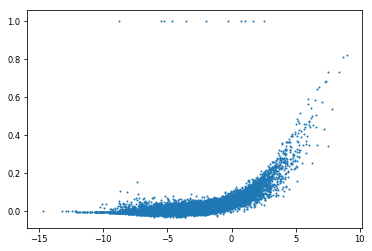

In [656]:
plt.scatter(means[sample_idxs], raw_corrs[sample_idxs], s=1)
condition = np.isfinite(raw_corrs[sample_idxs])
stats.pearsonr(means[sample_idxs][condition], raw_corrs[sample_idxs][condition])

(-0.008869409665721239, 0.375686925836576)

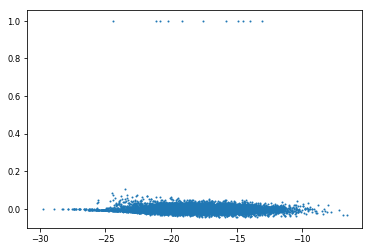

In [657]:
plt.scatter(norm_means[sample_idxs], norm_corrs[sample_idxs], s=1)
condition = np.isfinite(norm_corrs[sample_idxs])
stats.pearsonr(norm_means[sample_idxs][condition], norm_corrs[sample_idxs][condition])

Text(0, 0.5, 'estimated correlation')

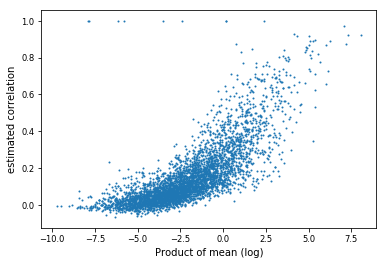

In [480]:
plt.scatter(means[sample_idxs], estimated_corrs[sample_idxs], s=1)
condition = np.isfinite(estimated_corrs[sample_idxs]) & np.isfinite(means[sample_idxs])
stats.pearsonr(means[sample_idxs][condition], estimated_corrs[sample_idxs][condition])
# plt.ylim(-0.25, 0.25)
plt.xlabel('Product of mean (log)');plt.ylabel('estimated correlation')